# Outliers detection methods

In [1]:
from IPython.display import Image
img = 'Algorithm.png'
Image(url=img, width=800)

# Introduction

Including outliers in data driven models could be risky. The existence of an extreme single misleading value has the potential to change the conclusion implied by the model. It is therefore important to manage that kind of risk.

This study **explains** six of the most popular **outlier detection methods**:
* Tukey's IQR method
* Standard deviation method
* Z-score method
* Modified z-score
* Isolation Forest
* DBSCAN - Density-Based Spatial Clustering of Applications with Noise

The goal of this study is to present some useful methods to detect and get rid of the outliers in a data set. Some of them are sensitive to extreme values like the SD method, and others are resistant to extreme values, like Tukey’s method.

## Table of Contents
* 1. Set-up
    * 1.1 Import Libraries
    * 1.2 Import Data
    * 1.3 Defining list of Features
    * 1.4 Some Visualisations
* 2. Tukey's IQR method
* 3. Standard deviation method
* 4. Z-score method
* 5. Modified z-score
* 6. Isolation Forest
* 7. DBSCAN - Density-Based Spatial Clustering of Applications with Noise

# 1. Set-up

I decided to use anonymized credit card transactions labeled as fraudulent or genuine as an example.

Source: https://www.kaggle.com/datasets/whenamancodes/fraud-detection

### 1.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from collections import Counter

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

%matplotlib inline

### 1.2 Import Data

In [3]:
df_raw = pd.read_csv('creditcard.csv')
df=df_raw.drop(['Time'], axis=1)

### 1.3 Defining list of Features

In [4]:
feature_list = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

### 1.4 Some Visualisations

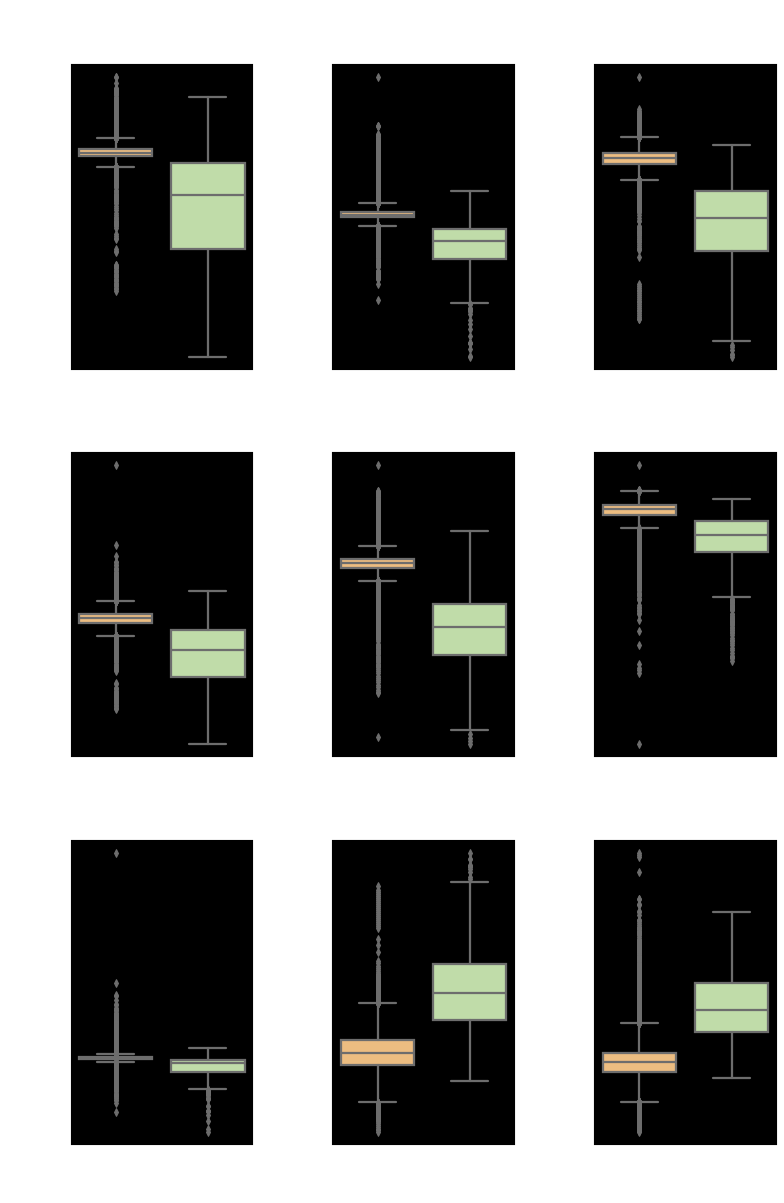

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(11,17))
fig.suptitle('Features vs Class\n', size = 18)

sns.boxplot(ax=axes[0, 0], data=df, x='Class', y='V17', palette='Spectral')
axes[0,0].set_title("V17 distribution");

sns.boxplot(ax=axes[0, 1], data=df, x='Class', y='V10', palette='Spectral')
axes[0,1].set_title("V10 distribution");

sns.boxplot(ax=axes[0, 2], data=df, x='Class', y='V12', palette='Spectral')
axes[0,2].set_title("V12 distribution");

sns.boxplot(ax=axes[1, 0], data=df, x='Class', y='V16', palette='Spectral')
axes[1,0].set_title("V16 distribution");

sns.boxplot(ax=axes[1, 1], data=df, x='Class', y='V14', palette='Spectral')
axes[1,1].set_title("V14 distribution");

sns.boxplot(ax=axes[1, 2], data=df, x='Class', y='V3', palette='Spectral')
axes[1,2].set_title("V3 distribution");

sns.boxplot(ax=axes[2, 0], data=df, x='Class', y='V7', palette='Spectral')
axes[2,0].set_title("V7 distribution");

sns.boxplot(ax=axes[2, 1], data=df, x='Class', y='V11', palette='Spectral')
axes[2,1].set_title("V11 distribution");

sns.boxplot(ax=axes[2, 2], data=df, x='Class', y='V4', palette='Spectral')
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

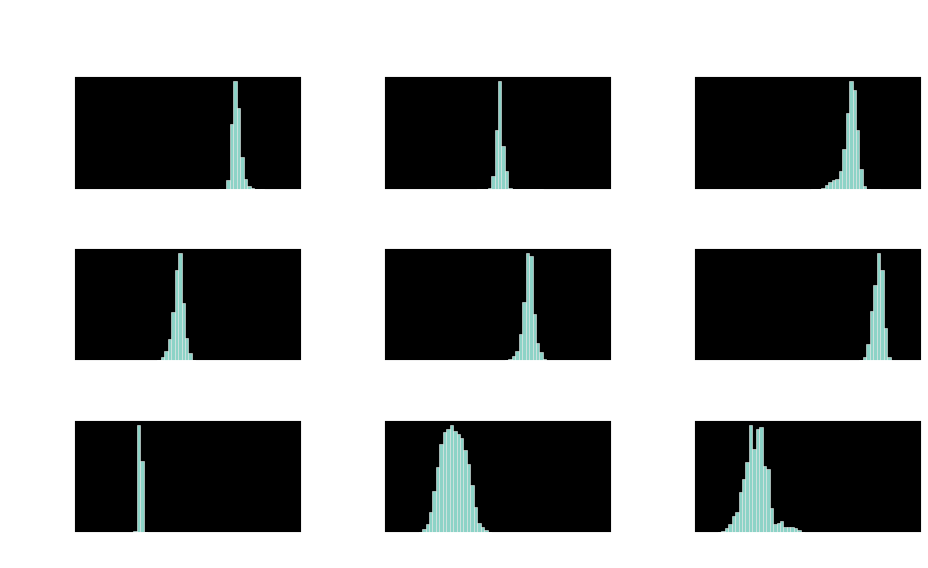

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Features vs Class\n', size = 18)

axes[0,0].hist(df['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 2. Tukey's IQR method

Tukey’s  (1977)  technique  is  used  to  detect  outliers  in  **skewed or non bell-shaped data** since it makes no distributional assumptions. However, Tukey’s method may not be appropriate for a small sample size. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:
1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

Any data point outside this range is considered as outlier and should be removed for further analysis.

In [7]:
img = 'IQR.png'
Image(url=img, width=800)

In [8]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < Q1 - outlier_step]
    df2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [9]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,feature_list)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of outliers is: 31904


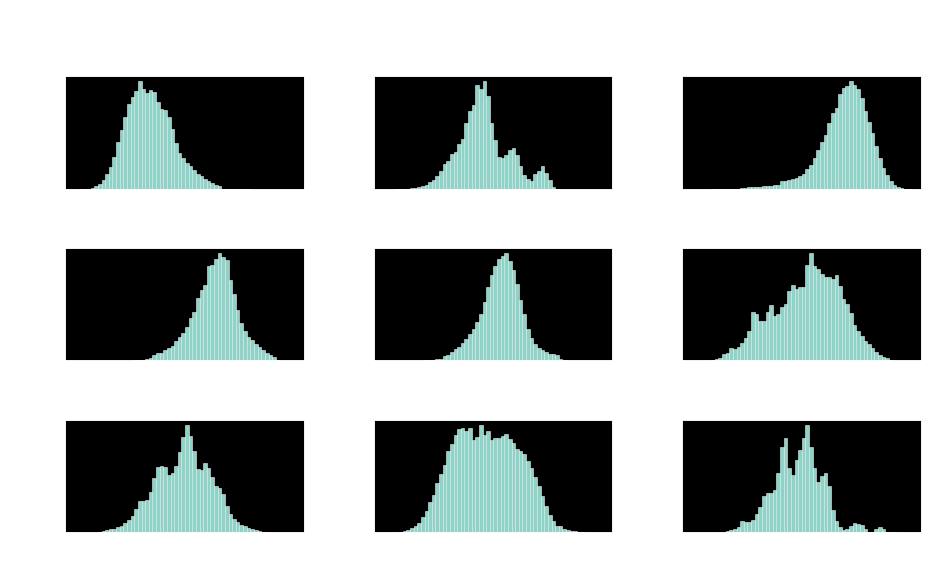

In [10]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using IQR Method\n', size = 18)

axes[0,0].hist(df_out['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 3. Standard deviation method

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

Standard deviation shows how much the individual data points are spread out from the mean. If a data distribution is normal then: 
* 68% of the data values lie within one standard deviation of the mean
* 95% are within two standard deviations
* 99.7% lie within three standard deviations.

Depending on the set specification either at 2 times stdev or 3 times stdev, we can detect and remove outliers from the dataset.

This method can fail to detect outliers because the outliers increase the standard deviation. The more extreme the outlier, the more the standard deviation is affected.

In [11]:
img = 'StDev.png'
Image(url=img, width=800)

In [12]:
def StDev_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the standard deviation method.
    """
    outlier_indices = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        
        # calculate the cutoff value
        cut_off = data_std * 3
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column = df[(df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_indices.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > data_mean + cut_off]
    df2 = df[df[column] < data_mean - cut_off]
    print('Total number of outliers is:', df1.shape[0]+ df2.shape[0])
    
    return multiple_outliers   

# detecting outliers
Outliers_StDev = StDev_method(df,1,feature_list)

# dropping outliers
df_out2 = df.drop(Outliers_StDev, axis = 0).reset_index(drop=True)

Total number of outliers is: 4076


The lower bound value is: -3.062139083134656
The upper bound value is: 3.062139083134658


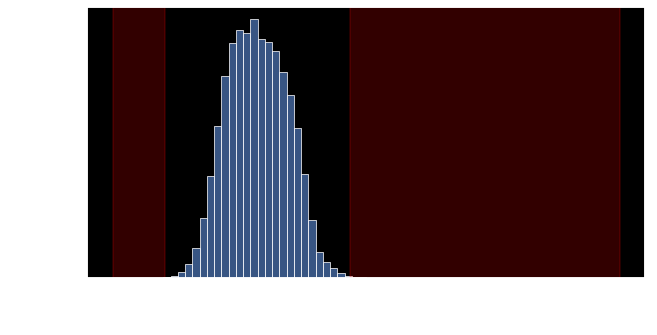

In [13]:
data_mean, data_std = df['V11'].mean(), df['V11'].std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

print('The lower bound value is:', data_mean - cut_off)
print('The upper bound value is:', data_mean + cut_off)

plt.figure(figsize = (10,5))
sns.histplot(x = 'V11', data=df, bins=70)
plt.axvspan(xmin = lower,xmax= df.V11.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df.V11.max(),alpha=0.2, color='red')

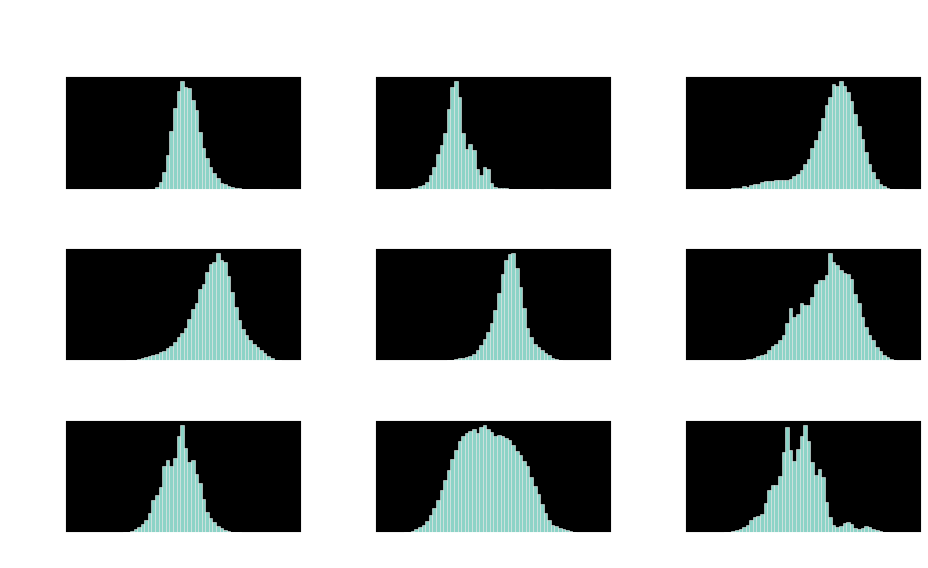

In [14]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using Standard Deviation Method\n', size = 18)


axes[0,0].hist(df_out2['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out2['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out2['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out2['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out2['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out2['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out2['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out2['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out2['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 4. Z-score method

While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. Z-score is used to convert the data into another dataset with mean = 0.

Z-score describes the position of a raw score in terms of its distance from the mean, when measured in standard deviation units.

This technique assumes a **Gaussian distribution** of the data. The outliers are the data points that are in the tails of the distribution.

In [15]:
img = 'zscore.png'
Image(url=img, width=600)

In [16]:
def z_score_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        
        z_score = abs( (df[column] - data_mean)/data_std )
        
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[z_score > threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[z_score > threshold]
    print('Total number of outliers is:', df1.shape[0])
    
    return multiple_outliers

In [17]:
# detecting outliers
Outliers_z_score = z_score_method(df,1,feature_list)

# dropping outliers
df_out3 = df.drop(Outliers_z_score, axis = 0).reset_index(drop=True)

Total number of outliers is: 4076


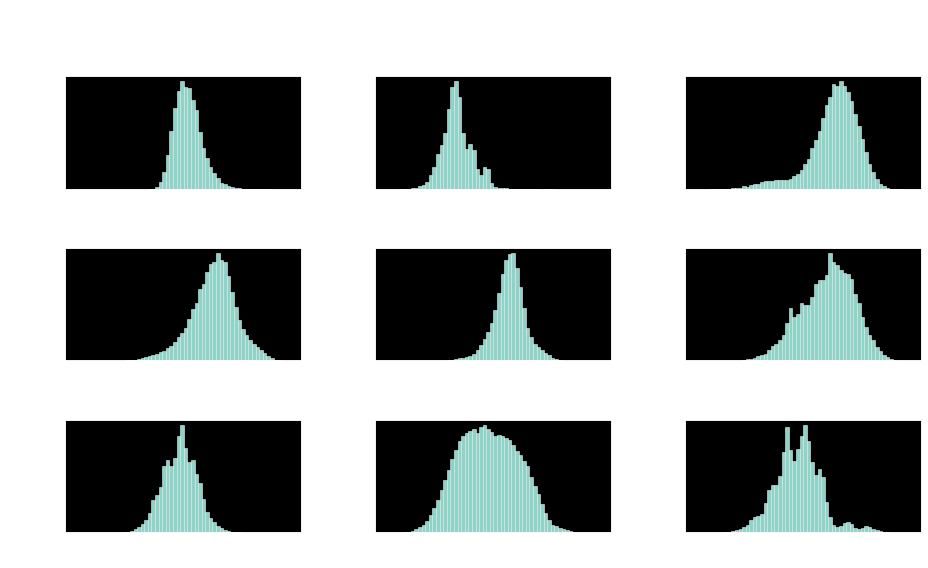

In [18]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using z-score\n', size = 18)

axes[0,0].hist(df_out3['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out3['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out3['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out3['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out3['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out3['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out3['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out3['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out3['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 5. Modified z-score

Z-scores can be affected by unusually large or small data values. If there is one extreme value, the z-score corresponding to that point will also be extreme which is why a more robust way to detect outliers is to use a modified z-score. 

It has the potential to significantly move the mean away from its actual value. Modified z-score is calculated as:

Modified z-score = 0.6745(xi – x̃) / MAD

where:

* xi: A single data value
* x̃: The median of the dataset
* MAD: The median absolute deviation of the dataset

The median absolute deviation (MAD) is a robust statistic of variability that measures the spread of a dataset. It’s less affected by outliers than other measures of dispersion like standard deviation and variance. If your data is normal, the standard deviation is usually the best choice for assessing spread. However, if your data isn’t normal, the MAD is one statistic you can use instead.

MAD = median(|xi – xm|)

where:
* xi: The ith value in the dataset
* xm: The median value in the dataset

### Important note 

To calculate MAD you can use:
* scipy.stats
* statsmodels
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_abs_deviation.html
https://www.statsmodels.org/dev/generated/statsmodels.robust.scale.mad.html

The formula from scipy.stats doesn't need any change in parameters.

The the formula from statsmodels (statsmodels.robust.scale.mad) howeaver computes a robust estimate of the standard deviation assuming a normal distribution by scaling the result by a factor of roughly 0.67.

To avoid using this scaling factor we have to set c = 1 as follows: robust.mad(data, c=1)

In [19]:
img = 'modZ.png'
Image(url=img, width=600)

In [20]:
from scipy.stats import median_abs_deviation

def z_scoremod_method (df,n,features):
    """
    Takes a dataframe df of features and returns an index list corresponding to the observations 
    containing more than n outliers according to the z-score modified method.
    """
    outlier_list = []
    
    for column in features:
        # calculate the mean and standard deviation of the data frame
        data_mean = df[column].mean()
        data_std = df[column].std()
        threshold = 3
        MAD = median_abs_deviation
        
        mod_z_score = abs(0.6745*(df[column] - data_mean)/MAD(df[column]) )
                
        # Determining a list of indices of outliers for feature column        
        outlier_list_column =  df[mod_z_score >threshold].index
        
        # appending the found outlier indices for column to the list of outlier indices 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of outlier records
    df1 = df[mod_z_score >threshold]
    print('Total number of outliers is:', df1.shape[0])
    
    return multiple_outliers

In [21]:
# detecting outliers
Outliers_z_score = z_scoremod_method(df,1,feature_list)

# dropping outliers
df_out4 = df.drop(Outliers_z_score, axis = 0).reset_index(drop=True)

Total number of outliers is: 33055


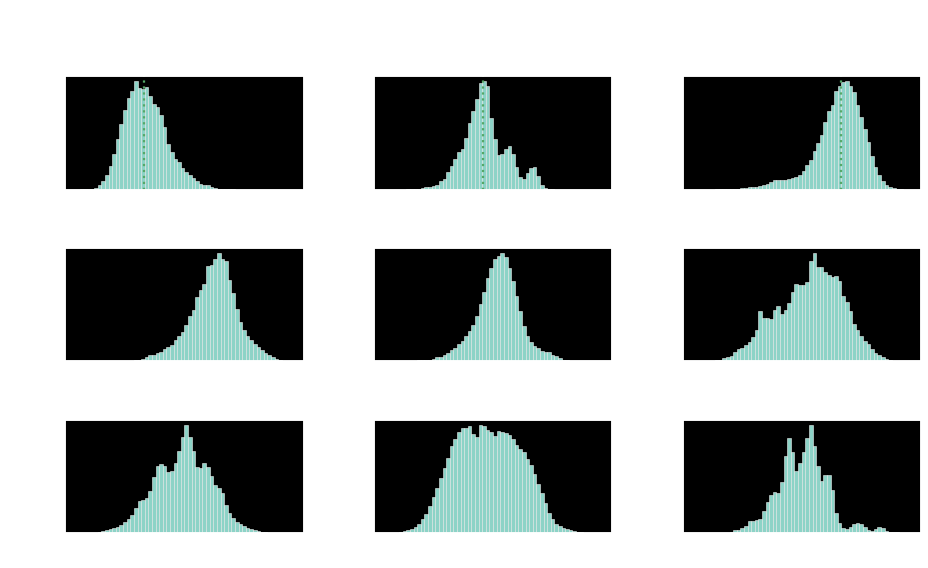

In [22]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using modified z-score\n', size = 18)

axes[0,0].hist(df_out4['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out4['V17']), ls=':', c='g', label="Median")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out4['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out4['V10']), ls=':', c='g', label="Median")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out4['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out4['V12']), ls=':', c='g', label="Median")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out4['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out4['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out4['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out4['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out4['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out4['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 6. Isolation Forest

Isolation Forest(IF) is similar to Random Forest and it is build based on decision trees. There are no pre-defined labels here. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data. 

The Isolation Forest (iForest) algorithm was initially proposed by Fei Tony Liu, Kai Ming Ting and Zhi-Hua Zhou in 2008. The authors took advantage of two quantitative properties of anomalous data points in a sample:

1. Few - they are the minority consisting of fewer instances and
2. Different - they have attribute-values that are very different from those of normal instances

Since the Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, this should make them easier to identify.

Isolation Forest does not assume normal distribution and is able to detect outliers at a multi-dimensional level. Isolation Forest is computationally efficient: the algorithm has a linear time complexity with a low constant and a low memory requirement. Therefore, it scales well to large data sets.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [23]:
img = 'iforest.png'
Image(url=img, width=600)

In [24]:
from sklearn.ensemble import IsolationForest

df5 = df.copy()
df5 = df5.drop(['Class'], axis=1)

**Number of estimators**: n_estimators refers to the number of base estimators or trees in the ensemble (the number of trees that will get built in the forest). This is an optional integer parameter. The default value is 100.

**Max samples**: max_samples is the number of samples to be drawn to train each base estimator. The default value of max_samples is 'auto' (256): If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling).

**Contamination**: it refers to the expected proportion of outliers in the data set (i.e. the proportion of outliers in the data set). This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest. If float, the contamination should be in the range (0, 0.5].

**Max features**: All the base estimators are not trained with all the features available in the dataset. It is the number of features to draw from the total features to train each base estimator or tree.The default value of max features is 1.

In [25]:
model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(df5)

C:\Users\mrute\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, n_estimators=150)

### Adding the scores and anomaly column
These columns are going to be added to the data frame df. 

Negative score value "-1" for the value of anomaly columns indicate the presence of anomaly. Value of "1" for the anomaly represents the normal data.

In [26]:
scores=model.decision_function(df5)
anomaly=model.predict(df5)

df5['scores']=scores
df5['anomaly']=anomaly

df5.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.065041,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.096838,1
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-0.016223,-1
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.050975,1
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.071621,1
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.096160,1
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.087332,1
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,-0.044879,-1
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.051230,1
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.085929,1


In [27]:
anomaly = df5.loc[df5['anomaly']==-1]
anomaly_index = list(anomaly.index)
print('Total number of outliers is:', len(anomaly))

Total number of outliers is: 28481


In [28]:
df5[df5['anomaly']==-1].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,scores,anomaly
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-0.016223,-1
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,-0.044879,-1
18,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,0.345173,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,-0.049399,-1
51,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,-0.230873,...,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,-0.059771,-1
69,-1.923213,-0.870482,2.320170,1.988776,0.417091,-0.380014,0.472139,-0.557333,-0.649079,1.410889,...,-0.779268,1.086055,0.518863,-0.363712,3.065576,-0.589022,-0.396110,35.00,-0.011847,-1
82,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,-0.115294,-1
83,-1.198968,-1.474100,1.840326,-4.515824,0.327567,-0.174469,0.959726,-1.026456,1.700435,-0.078942,...,0.334614,-0.364541,-0.310186,-0.302599,-1.243924,-1.123457,-0.734351,89.17,-0.036831,-1
85,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,-0.614312,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,-0.040576,-1
88,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,0.919513,-0.735586,...,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,-0.000789,-1
89,-0.773293,-4.146007,-0.932038,0.027094,-1.698307,0.460188,0.737344,-0.314216,-0.842673,0.017276,...,0.026123,-1.134769,-0.654958,0.098386,-0.209150,-0.171709,0.208057,1142.02,-0.015517,-1


In [29]:
# dropping outliers
df_out5 = df5.drop(anomaly_index, axis = 0).reset_index(drop=True)

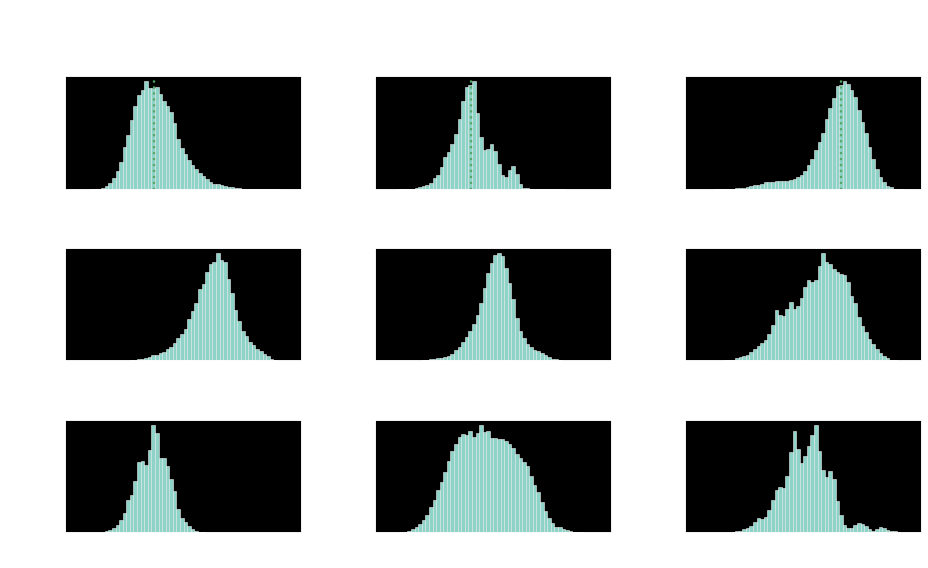

In [30]:
# Checking distributions of most important features after dropping outliers

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Distributions of most important features after dropping outliers using modified z-score\n', size = 18)

axes[0,0].hist(df_out5['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out5['V17']), ls=':', c='g', label="Median")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out5['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out5['V10']), ls=':', c='g', label="Median")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out5['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out5['V12']), ls=':', c='g', label="Median")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out5['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out5['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out5['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out5['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out5['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out5['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

# 7. DBSCAN - Density-Based Spatial Clustering of Applications with Noise

DBSCAN is a powerful density-based data clustering algorithm. Clustering is an unsupervised learning technique where we try to group the data points based on specific characteristics. DBSCAN was proposed by Martin Ester et al. in 1996. It works on the assumption that clusters are dense regions in space separated by regions of lower density.

To cluster data points DBSCAN algorithm separates the high-density regions of the data from the low-density areas. It uses distance and a minimum number of points per cluster to classify a point as an outlier. This approch is similar to the K-mean clustering.

PARAMETERS:

**Epsilon** is the radius of the circle to be created around each data point to check the density.

**minPoints** is the minimum number of data points required inside that circle for that data point to be classified as a Core point. This includes the point itself.

In higher dimensions the circle becomes hypersphere, epsilon becomes the radius of that hypersphere, and minPoints is the minimum number of data points required inside that hypersphere.

**DBSCAN algorithm doesn't make assumptions about how data are distributed.**

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [39]:
df6 = df.copy()
df6 = df6.drop(['Class'], axis=1)

In [38]:
img = 'DBSCAN.png'
Image(url=img, width=800)

Let’s first run DBSCAN without any parameter optimization and see the results.

In [48]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# scale data first
X = StandardScaler().fit_transform(df6.values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [64]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('The number of clusters in dataset is:', n_clusters_)

The number of clusters in dataset is: 39


The number of clusters does not include outliers/noise in the dataset.

Labels are the labels of the clusters. If the label is -1, then the observation is an outlier/noise.

In [50]:
pd.Series(labels).value_counts()

 0     197235
 1      32473
-1      20243
 9      16078
 2      12290
 5       2047
 7       1416
 10       828
 3        333
 24       287
 12       214
 16       213
 13       206
 17       181
 11       170
 18        81
 4         80
 30        48
 37        36
 20        32
 22        32
 23        25
 31        24
 14        21
 29        20
 15        19
 25        18
 28        17
 26        16
 33        16
 21        15
 32        14
 34        12
 35        12
 38        10
 6         10
 8         10
 36        10
 19         8
 27         7
dtype: int64

# Thanks, upvote if you liked it :)